In [1]:
import os
import glob
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
from osgeo import gdal
import xarray as xr
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import matplotlib.pyplot as plt

import utils

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Get datasets

In [2]:
# Get filenames
ndvi_filenames = sorted(glob.glob("files/*.hdf"))
era5_filenames = sorted(glob.glob("era5_land_data/*/*"))

len(ndvi_filenames), len(era5_filenames)

(646, 2)

In [3]:
era_ds = utils.combine_resample_era5(
    era5_filenames, xbounds=utils.xbounds, ybounds=utils.ybounds
)
era_ds

<xarray.Dataset>
Dimensions:  (x: 131, y: 66, time: 640)
Coordinates:
  * x        (x) float32 -101.0 -100.9 -100.8 -100.7 ... -88.3 -88.2 -88.1 -88.0
  * y        (y) float32 46.5 46.4 46.3 46.2 46.1 ... 40.4 40.3 40.2 40.1 40.0
  * time     (time) datetime64[ns] 2010-01-01 2010-01-09 ... 2023-12-31
Data variables:
    t2m      (time, y, x) float32 251.7 251.8 251.8 251.9 ... 272.9 272.9 272.8
    tp       (time, y, x) float32 0.001198 0.001222 ... 6.072e-06 6.072e-06
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-21 20:44:38 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

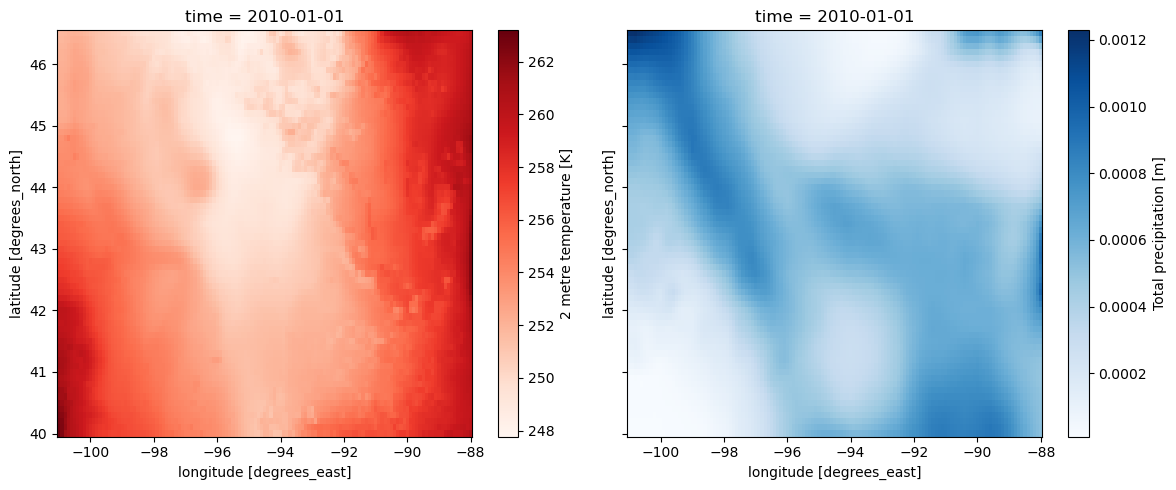

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
axes = axes.ravel()
era_ds["t2m"].isel(time=0).plot(cmap="Reds", ax=axes[0])
era_ds["tp"].isel(time=0).plot(cmap="Blues", ax=axes[1])
plt.tight_layout()
plt.show()

In [5]:
ndvi_ds = utils.combine_resample_ndvi(
    ndvi_filenames, coarse_ds=era_ds, xbounds=utils.xbounds, ybounds=utils.ybounds
)
ndvi_ds

Combining 646 NDVI files (2 grids & 323 dates) and coarsening to resolution: 0.09999847412109375


100%|██████████| 323/323 [10:44<00:00,  2.00s/it]


<xarray.Dataset>
Dimensions:      (x: 147, y: 74, band: 1, time: 640)
Coordinates:
  * x            (x) float64 -101.0 -100.9 -100.8 -100.7 ... -88.3 -88.21 -88.12
  * y            (y) float64 46.46 46.37 46.28 46.19 ... 40.3 40.21 40.12 40.03
  * band         (band) int64 1
  * time         (time) datetime64[ns] 2009-12-19 2009-12-27 ... 2023-12-18
    spatial_ref  int64 0
Data variables:
    ndvi         (time, band, y, x) float64 -246.2 -199.9 ... 2.616e+03

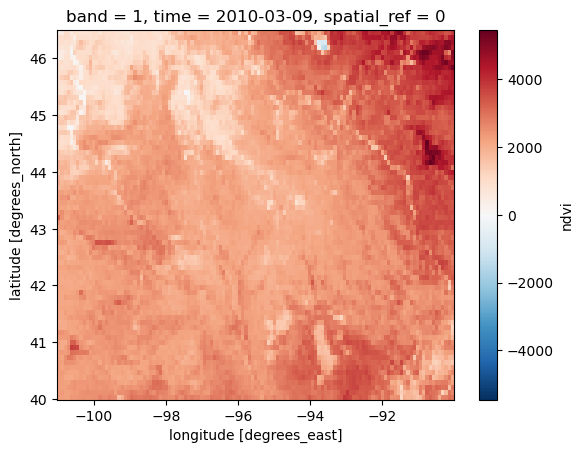

In [26]:
ndvi_ds["ndvi"].isel(time=10).sel(x=slice(-110, -90)).plot()

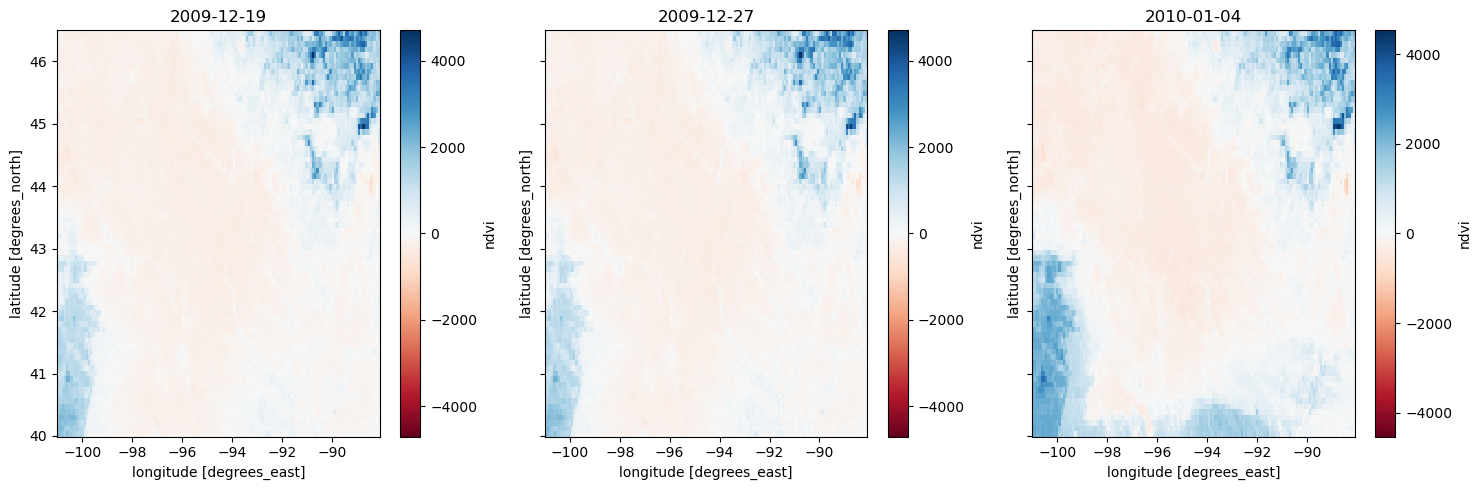

In [27]:
n = 3
fig, axes = plt.subplots(1, n, figsize=(15, 5), sharex=True, sharey=True)
axes = axes.ravel()
for i in range(n):
    ndvi_ds["ndvi"].isel(time=i).plot(cmap="RdBu", ax=axes[i])
    axes[i].set_title(str(ndvi_ds["time"].values[i])[:10])
plt.tight_layout()
plt.show()

In [28]:
ds = rxr.open_rasterio("additional/GFSAD1KCD.2010.001.2016348142525.tif")
ds

<xarray.DataArray (band: 1, y: 20160, x: 40430)>
[815068800 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.9 180.9 180.9
  * y            (y) float64 90.0 89.99 89.98 89.97 ... -89.96 -89.97 -89.98
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_SOFTWARE:        IMAGINE TIFF Support\nCopyright 1991 - 1999 by E...
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

In [29]:
ds = ds.sel(band=1, x=utils.xbounds, y=utils.ybounds)
cds = utils.corsen_dataset(ds.copy(deep=True), era_ds)
cds

/opt/anaconda3/envs/gdal/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


<xarray.DataArray (y: 66, x: 131)>
array([[3, 3, 6, ..., 6, 6, 6],
       [3, 6, 3, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [7, 7, 7, ..., 8, 9, 9],
       [7, 7, 7, ..., 9, 9, 9],
       [7, 7, 7, ..., 9, 9, 9]], dtype=uint8)
Coordinates:
  * y            (y) float64 40.0 40.1 40.2 40.3 40.4 ... 46.2 46.3 46.4 46.5
  * x            (x) float64 -101.0 -100.9 -100.8 -100.7 ... -88.2 -88.1 -88.0
    band         int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_SOFTWARE:        IMAGINE TIFF Support\nCopyright 1991 - 1999 by E...
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

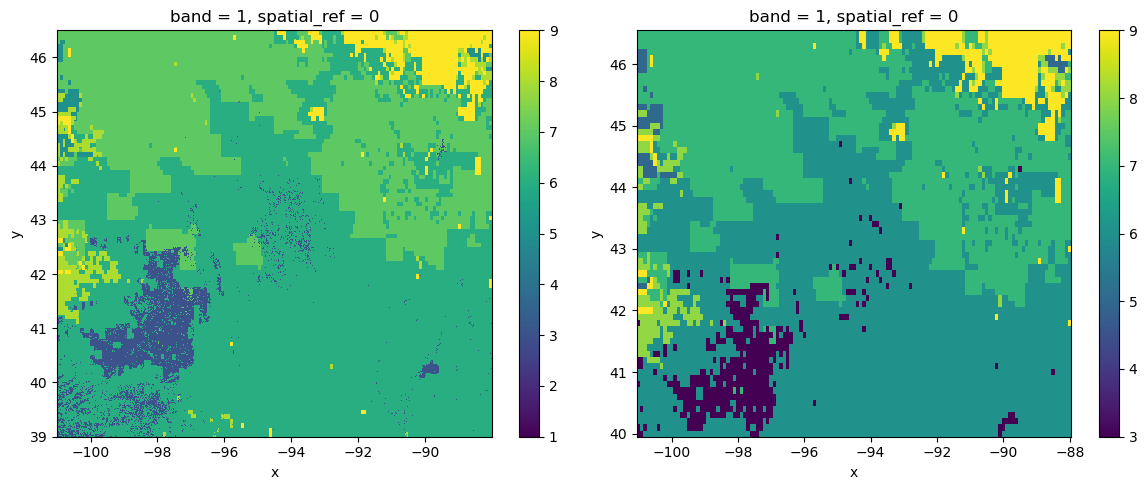

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ds.plot(ax=ax[0])
cds.plot(ax=ax[1])
plt.tight_layout()
plt.show()

### Merge datasets

In [31]:
ds = xr.merge(
    [
        ndvi_ds.isel(band=0).copy(deep=True),
        era_ds.reindex_like(ndvi_ds, method="nearest").copy(deep=True),
    ]
)
ds

<xarray.Dataset>
Dimensions:      (x: 147, y: 74, time: 640)
Coordinates:
  * x            (x) float64 -101.0 -100.9 -100.8 -100.7 ... -88.3 -88.21 -88.12
  * y            (y) float64 46.46 46.37 46.28 46.19 ... 40.3 40.21 40.12 40.03
    band         int64 1
  * time         (time) datetime64[ns] 2009-12-19 2009-12-27 ... 2023-12-18
    spatial_ref  int64 0
Data variables:
    ndvi         (time, y, x) float64 -246.2 -199.9 ... 3.164e+03 2.616e+03
    t2m          (time, y, x) float32 251.7 251.8 251.8 ... 274.7 274.6 274.6
    tp           (time, y, x) float32 0.001198 0.001222 ... 0.0004881 0.0005521
    y_c          (y) float32 46.5 46.4 46.3 46.2 46.1 ... 40.3 40.2 40.1 40.0
    x_c          (x) float32 -101.0 -100.9 -100.8 -100.7 ... -88.3 -88.2 -88.1

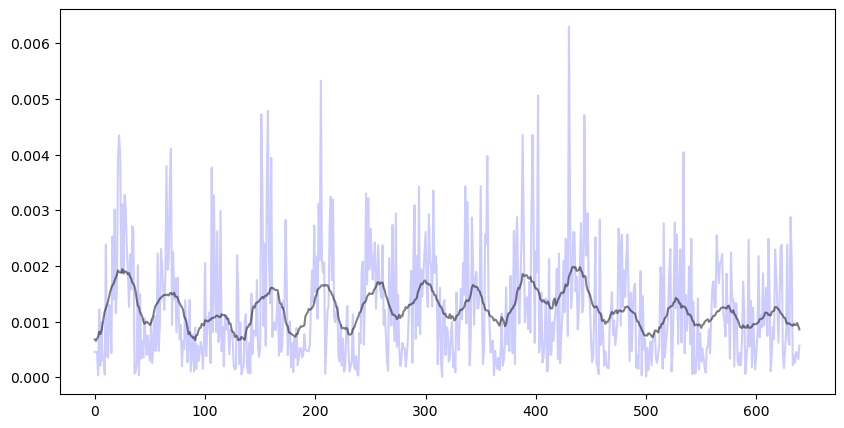

In [32]:
# Get 1m moving average for precipitation
ds["tp_original"] = ds["tp"]
ds["tp"] = xr.DataArray(
    utils.moving_average_3d(ds["tp"].values, n=30, axis=0), dims=ds["tp"].dims
)

tp_original = np.mean(
    np.reshape(
        ds["tp_original"].values,
        (len(ds.time.values), len(ds.x.values) * len(ds.y.values)),
    ),
    axis=1,
)
tp = np.mean(
    np.reshape(
        ds["tp"].values, (len(ds.time.values), len(ds.x.values) * len(ds.y.values))
    ),
    axis=1,
)
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(tp_original, c="blue", alpha=0.2)
plt.plot(tp, c="black", alpha=0.5)

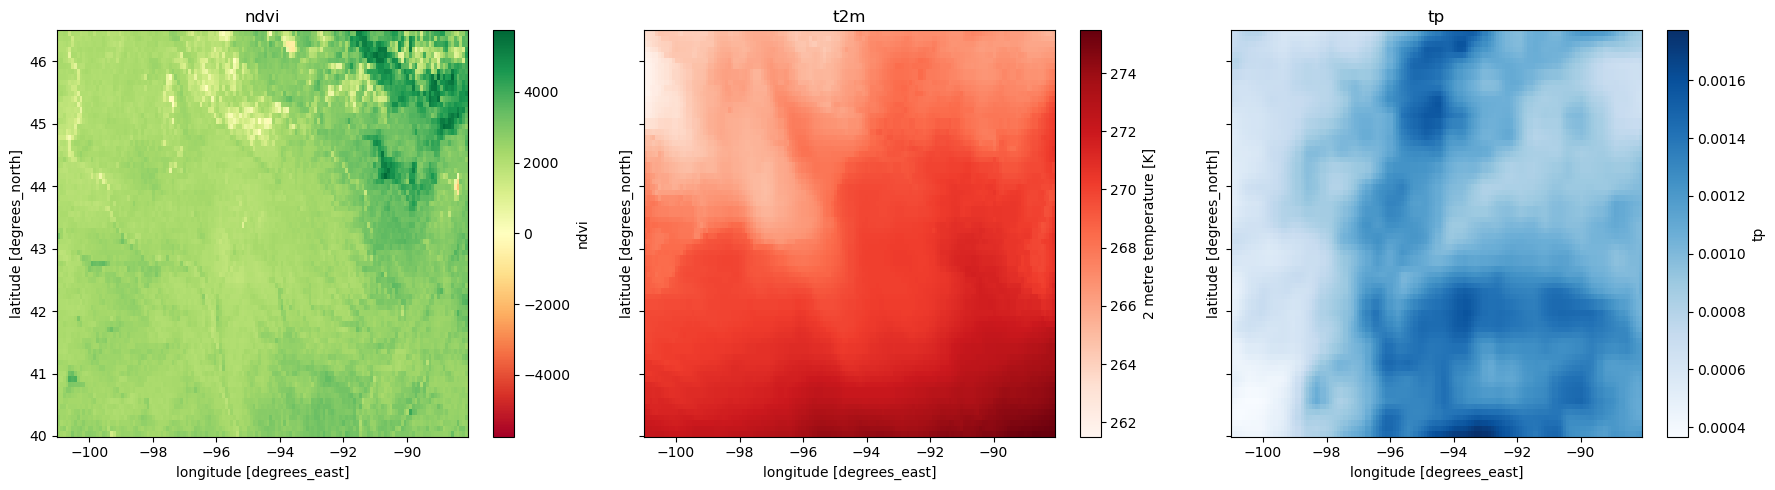

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
axes = axes.ravel()
for i, (var, cmap) in enumerate([("ndvi", "RdYlGn"), ("t2m", "Reds"), ("tp", "Blues")]):
    ds[var].isel(time=100).plot(cmap=cmap, ax=axes[i])
    axes[i].set_title(var)
plt.tight_layout()
plt.show()

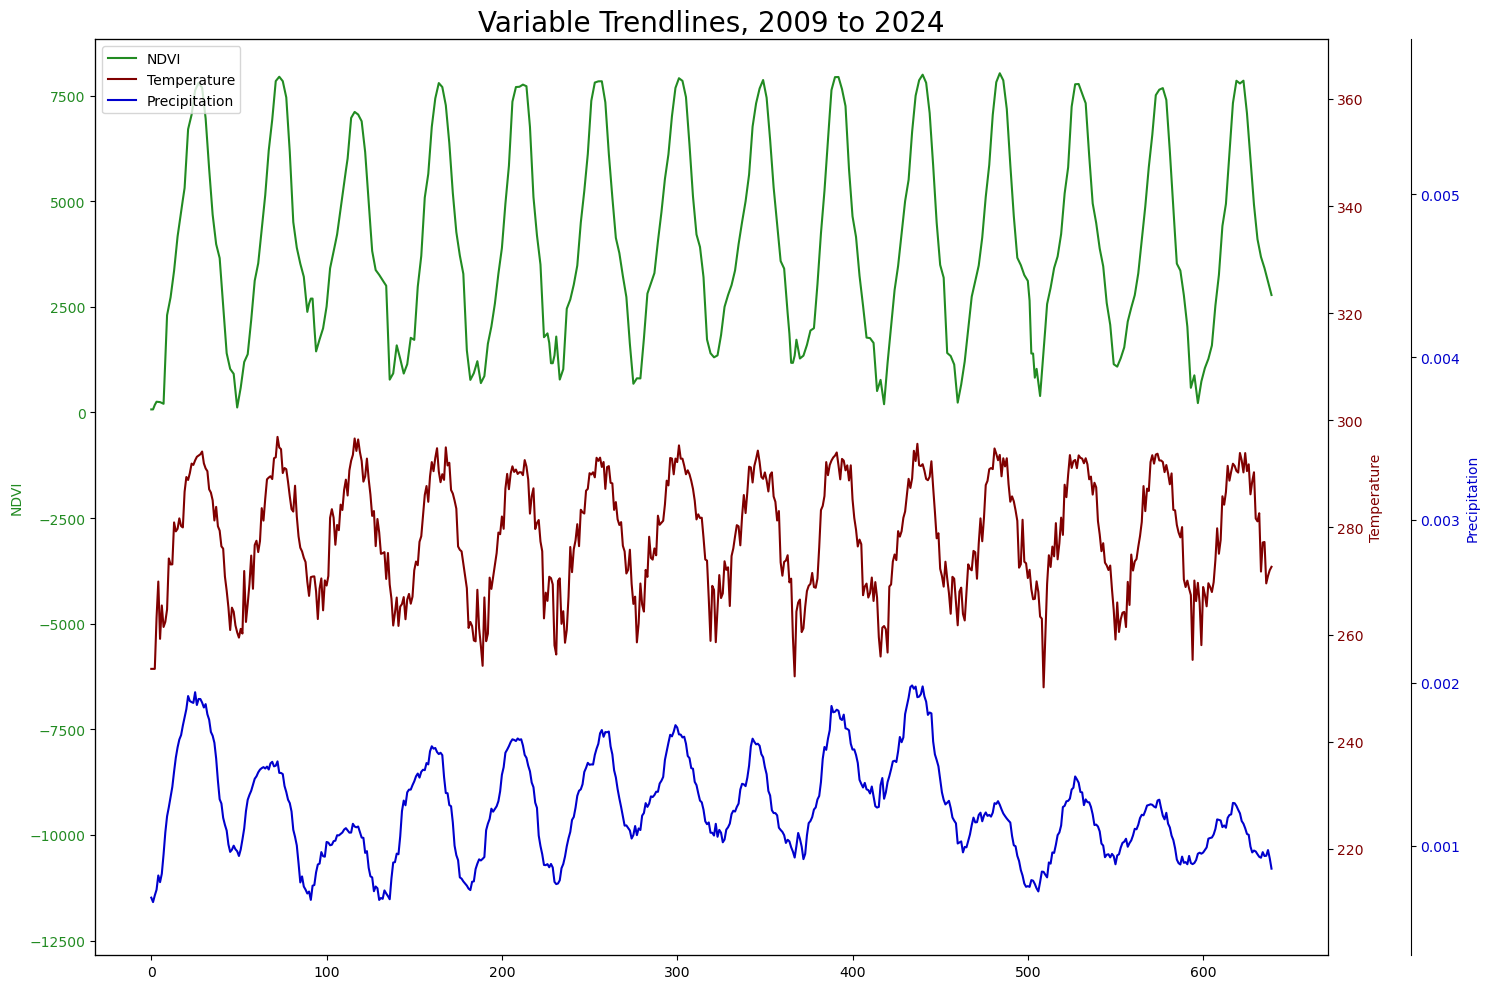

In [34]:
fig, ax1 = plt.subplots(figsize=(15, 10))

# Plot the first variable (NDVI) on the main axis
var, title, color = "ndvi", "NDVI", "forestgreen"
arr = ds[var].values.reshape(ds[var].values.shape[0], -1)
ndvi_arr = arr.copy()
arr = np.nanmean(arr, axis=1)
(line1,) = ax1.plot(arr, color=color, label=title)
ax1.set_ylabel(title, color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax1.set_ylim(-np.nanmax(arr) * 1.6, np.nanmax(arr) * 1.1)

# Create a twin axis for the second variable
ax2 = ax1.twinx()
var, title, color = "t2m", "Temperature", "maroon"
arr = ds[var].values.reshape(ds[var].values.shape[0], -1)
arr = np.nanmean(arr, axis=1)
(line2,) = ax2.plot(arr, color=color, label=title)
ax2.set_ylabel(title, color=color)
ax2.tick_params(axis="y", labelcolor=color)

ax2.set_ylim(np.nanmin(arr) * 0.8, np.nanmax(arr) * 1.25)

# Create another twin axis for the third variable, offset the spine
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # offset the third y-axis
var, title, color = "tp", "Precipitation", "mediumblue"
arr = ds[var].values.reshape(ds[var].values.shape[0], -1)
arr = np.nanmean(arr, axis=1)
(line3,) = ax3.plot(arr, color=color, label=title)
ax3.set_ylabel(title, color=color)
ax3.tick_params(axis="y", labelcolor=color)

ax3.set_ylim(np.min(arr) * 0.5, np.max(arr) * 3)

# Add a single legend
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left")

# Display the plot
plt.title("Variable Trendlines, 2009 to 2024", fontsize=20)
plt.tight_layout()
plt.savefig("variable_trendlines.png")
plt.show()

### Output

In [35]:
arr_path_out = "arrays"
os.makedirs(arr_path_out, exist_ok=True)

# Output variables
for var in utils.var_list:
    arr = ds[var].copy(deep=True).values
    if var == "ndvi":
        arr /= 10000
    path_out = os.path.join(arr_path_out, var)
    np.save(path_out, arr)

# Output dimensions
for title, dim in [("longitude", "x"), ("latitude", "y"), ("time", "time")]:
    np.save(os.path.join(arr_path_out, title), ds[dim].values)
    np.save(os.path.join(arr_path_out, title), ds[dim].values)
    np.save(os.path.join(arr_path_out, title), ds[dim].values)